<a href="https://colab.research.google.com/github/nauam/UnB_MAR/blob/main/MAR_Code_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
from numpy import sin, cos, sinc, pi, log10, diag, matmul as mult, array, zeros, ones, eye, sqrt, reshape, size, arange, amax, real
from numpy.linalg  import inv, norm
from scipy.special import spherical_jn, spherical_yn, lpmn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [30]:
def F_Q(u,n,theta):
  return theta/2*(sinc((u-n)*theta/pi) + sinc((u+n+1)*theta/pi))

def F_S(u,n,theta):
  S_mat = []
  for i_ in range(0, len(theta)):
    if theta[i_][i_] == 0:
        S_mat.append(0)
    else:
        S_mat.append(2/pi*(F_Q(u,n,theta[i_][i_]) - F_Q(u,0,theta[i_][i_])*F_Q(0,n,theta[i_][i_])/F_Q(0,0,theta[i_][i_])))
  return diag(S_mat)

def F_SphericalFunction(z,n):
  N = len(z)
  Z1 = zeros((N,N,n),dtype = 'complex_');  Z3 = zeros((N,N,n),dtype = 'complex_');  K1 = zeros((N,N,n),dtype = 'complex_');  K3 = zeros((N,N,n),dtype = 'complex_')
  n_ =  list(range(1,n+1))
  for i_ in range(0, N):
    Z1[i_][i_][:] = spherical_jn(n_, z[i_][i_], derivative=False)
    Z2            = spherical_yn(n_, z[i_][i_], derivative=False)
    Z3[i_][i_][:] = Z1[i_][i_][:] - 1j*Z2;

    K1[i_][i_][:] = spherical_jn(n_, z[i_][i_], derivative=True) + Z1[i_][i_][:]/z[i_][i_]
    K2            = spherical_yn(n_, z[i_][i_], derivative=True) + Z2           /z[i_][i_]
    K3[i_][i_][:] = K1[i_][i_][:] - 1j*K2;

  return Z1, Z3, K1, K3

def S_ProbeFedA(k0r, Ang1, Ang2):
  frq = 9*10**9
  c0  = 299792458
  k0  = 2*pi*frq/c0

  r    = diag([           1.000,    0.970])*k0r/k0
  th_r = diag([           Ang1 ,     Ang2])*pi/180
  ep_r = diag([  1.000,   1.300,    1.000])
  mu_r = diag([  1.000,   1.000,    1.000])

  return r, th_r, ep_r, mu_r, k0

def S_ProbeFedB():
  frq = 9*10**9
  c0  = 299792458
  k0  = 2*pi*frq/c0

  r    = diag([           0.038,   0.035])
  th_r = diag([          16.000, 160.000])*pi/180
  ep_r = diag([  1.000,   1.230,   1.000])
  mu_r = diag([  1.000,   1.000,   1.000])

  return r, th_r, ep_r, mu_r, k0

def S_ProbeFedDLL(k0r, Ang1, Ang2):
  frq = 5*10**9
  c0  = 299792458
  k0  = 2*pi*frq/c0

  L  = 6
  N  = L + 1
  tx = 0.75

  i_   = array(range(N-1,0,-1))
  r__i = list(i_/(N-1))
  th_i = list(zeros(N-2))
  ep_i = list(2 - ((2*i_-1)/(2*(N-1)))**2)
  mu_i = list(ones(N-1))

  r    = diag([       1.000] + r__i)*k0r/k0
  th_r = diag([ Ang1,  Ang2] + th_i)*pi/180
  ep_r = diag([1.000, 1.000] + ep_i)       
  mu_r = diag([1.000, 1.000] + mu_i)       

  return r, th_r, ep_r, mu_r, k0

def F_Formulation(n,k0r,Lens,Ang1,Ang2):
  if Lens == "A": [r, th_r, ep_r, mu_r, k__0] = S_ProbeFedA(k0r,Ang1,Ang2)
  elif Lens == "B": [r, th_r, ep_r, mu_r, k__0] = S_ProbeFedB()
  else:             [r, th_r, ep_r, mu_r, k__0] = S_ProbeFedDLL(k0r,Ang1,Ang2)
  N = len(r); src = 1; c0  = 299792458; et_0 = 4*pi*10**(-7)*c0;
  CZ = zeros((N,N,n),dtype = 'complex_'); G_ = zeros((N,N,n),dtype = 'complex_'); Yk_ = zeros((n,N),dtype = 'complex_'); Yz_ = zeros((n,N),dtype = 'complex_');

  k_i0 = k__0*sqrt(mult(mu_r[0:N  ,0:N  ],ep_r[0:N  ,0:N  ]));  et_i0 = et_0*sqrt(mult(mu_r[0:N  ,0:N  ],inv(ep_r[0:N  ,0:N  ])))
  k_i1 = k__0*sqrt(mult(mu_r[1:N+1,1:N+1],ep_r[1:N+1,1:N+1]));  et_i1 = et_0*sqrt(mult(mu_r[1:N+1,1:N+1],inv(ep_r[1:N+1,1:N+1])))
  fk   = ones(n); fz = (2*array(range(1,n+1))+1)/(array(range(1,n+1))*(array(range(1,n+1))+1));             Omg   = - inv(r/2*(mult(k_i0,inv(et_i0)) + mult(k_i1,inv(et_i1))))

  Ii = diag(ones(N-1),-1); di0 = array(list(map(int, src == array(range(0,N  )))))
  Is = diag(ones(N-1), 1); di1 = array(list(map(int, src == array(range(1,N+1)))))

  [Z1_i0,Z3_i0,K1_i0,K3_i0] = F_SphericalFunction(mult(k_i0,r),n);  [Z1_i1,Z3_i1,K1_i1,K3_i1] = F_SphericalFunction(mult(k_i1,r),n);

  for n_ in range(0, n):
    K1D =      K1_i1[:,:,n_];             K1E = mult(     K1_i0[:,:,n_]           ,Ii);    K1F =      K1_i0[:,:,n_];      	      K1T = K1D - K1E;
    K3D =      K3_i0[:,:,n_];  	          K3E = mult(     K3_i1[:,:,n_]           ,Is);    K3F =      K3_i1[:,:,n_];              K3T = K3D - K3E;
    Z1D = mult(Z1_i1[:,:,n_],inv(et_i1)); Z1E = mult(mult(Z1_i0[:,:,n_],inv(et_i0)),Ii);   Z1F = mult(Z1_i0[:,:,n_],inv(et_i0));	Z1T = Z1D - Z1E;
    Z3D = mult(Z3_i0[:,:,n_],inv(et_i0));	Z3E = mult(mult(Z3_i1[:,:,n_],inv(et_i1)),Is);   Z3F = mult(Z3_i1[:,:,n_],inv(et_i1));	Z3T = Z3D - Z3E;

    CKn   = K3D + mult(mult(K1E,inv(K1T)),K3T);                       CZn  = Z3T - mult(mult(Z1T,inv(K1T)),K3T);                      CZ[:,:,n_] = CZn;

    Del = -(2*(n_+1)+1)*(mu_r[src,src]/(4.*pi*r[src,src]));               Del1 =  Z1_i0[src,src,n_]*Del*di1;                              Del2 =  Z3_i0[src,src,n_]*Del*di0;
    Ckn1 = mult(      mult(mult(K1E,inv(K1T)),K3F),Del1);             Ckn2 = - mult(mult(eye(N) +      mult(K1E,inv(K1T)),K1F),Del2)
    Czn1 = mult(Z3F - mult(mult(Z1T,inv(K1T)),K3F),Del1);             Czn2 = -      mult( Z1F   - mult(mult(Z1T,inv(K1T)),K1F),Del2)

    G_[:,:,n_] = eye(N) - fz[n_]/fk[n_]*mult(CKn,inv(mult(Omg,CZn))); Yk_ [n_,:] = mult(inv(Omg),Ckn1 + Ckn2)*fk[n_];                 Yz_ [n_,:] = (Czn1 + Czn2)/fz[n_]

  A_ = zeros((n,N,n,N),dtype = 'complex_'); S_ = zeros((n,N,n,N),dtype = 'complex_'); B3 = zeros((N,n),dtype = 'complex_');           P1n = zeros((1000,n),dtype = 'complex_');
  for u_ in range(0, n):
    for n_ in range(0, n):
      A_[u_,:,n_,:] = mult(mult(F_S(u_+1,n_+1,th_r),inv(Omg)),mult(G_[:,:,n_],Omg))
      S_[u_,:,n_,:] =      F_S(u_+1,n_+1,th_r)

  A = reshape(A_,(N*n,N*n));  S = reshape(S_,(N*n,N*n));  
  Yk = reshape(Yk_,(N*n));  Yz = reshape(Yz_,(N*n));  
  B = Yz + mult(S,(Yk - Yz)); 
  X_ = mult(inv(eye(N*n)-A),B); X = reshape(X_,(n,N))

  for n_ in range(n):
    B3[:,n_] = fz[n_]*mult(inv(CZ[:,:,n_]),X[n_,:])

  return X[:,0], B3

def F_plot(B,p,n):
  P1n = zeros((1000,n),dtype = 'complex_');
  Cos = cos(arange(0,2*pi,pi/500))
  for i_ in range(1000):
    Pmn = lpmn(1, n,Cos[i_])
    P1n[i_,:] = Pmn[0][1][1:n+1]

  ffp = abs(mult(mult(P1n,diag(B[0,:])),(1j)**arange(1,n+1)))+1
  FFP = ffp/amax(ffp)

  plt.plot(arange(0,2*pi,pi/500)*180/pi,20*log10(FFP))
  plt.xlabel('Theta [deg]')  # string must be enclosed with quotes '  '
  plt.ylabel('dB20normalize(rETotal)')
  plt.title('Diagrama de Campo Distante')
  plt.grid(True)
  plt.show()

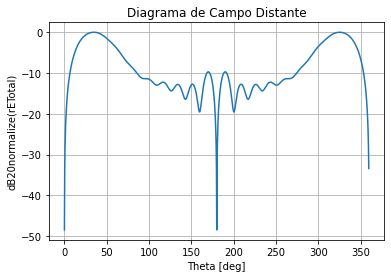

In [31]:
n = 50
[X,B] = F_Formulation(n,9.94,'A',18,180)
F_plot(B,'cart',n)

100%|██████████| 148/148 [14:26<00:00,  5.85s/it]


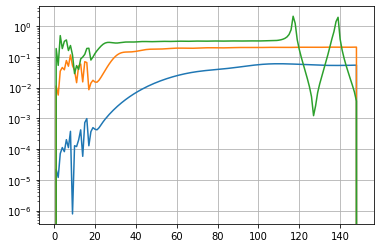

In [77]:
n = 150
k0r = 20.94
Lens = "D"
Ang2 = 2
arr = range(2,3*5,5)
X  = zeros((n,n,len(arr)),dtype = 'complex_')
er = zeros((n,len(arr)))

i = 0
for Ang2 in arr:
  n_ = 1
  [X[range(n_),n_-1,i],B] = F_Formulation(n_,k0r,Lens,2*Ang2,Ang2)
  for n_ in tqdm(range(2,n)):
    [X[range(n_),n_-1,i],B] = F_Formulation(n_,k0r,Lens,2*Ang2,Ang2)
    er[n_-1,i] = norm(X[range(n_-1),n_-1,i]-X[range(n_-1),n_-2,i])/norm(X[range(n_-1),n_-1,i])
  i = i+1
plt.semilogy(arange(n),er[:,0],arange(n),er[:,1],arange(n),er[:,2])
plt.grid(True)
plt.show()